### Supervised learning problem - Classification Algorithms 

In this notebook multiple algorithm is used solve a classification problem. The algorithms are **SVM, KNN, Random Forest, XGBoost**.

#### Dataset title:
Online Shoppers Purchasing Intention Dataset
[Dataset link](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)


#### Dataset description by the data provider:
The dataset consists of 10 numerical and 8 categorical attributes.
The "Revenue" attribute can be used as the class label.

- "Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.
  
The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. 

- Bounce Rate: refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.
- Exit Rate: for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. - Page Value: feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
- Special Day: feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine"s Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.
- The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

#### Research questions to answer:
1. What is the correlation between each feature and the target?
2. What is the proper evaluation metric to use if:
   1. There are limited financial resources to advertise the products and it is important to advertise mainly to those who are most probably actual buyers
   2. The aim is to reach as many potential buyers as possible (assuming the resources is not limited)
3. Which time of the year is best to increase advertisement on the website?
4. Which of the SVM, KNN, Random Forest, and XGBoost models perform best in predicting if a website visitor will purchase any product from the online shop?
5. How feature selection impact the best found model?

#### Import dependencies 

In [1]:
from IPython.display import display

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from utils.data_wrangling_utils import categorical_encoder, data_normalizer
from utils.evaluation import model_evaluation
from utils.models import grid_search
from utils.visualizations import plot_data_distribution, plot_auc_roc_curve



#### Get to know the dataset

In [2]:
# load the dataset
df = pd.read_csv("online_shoppers_intention.csv")

- In the following cell result, there are 3 rows of data displayed as examples.
- Note that there are 18 columns in the dataset, from which `Revenue` contains the labels.
- The dataset consists of 12330 instances. 

In [3]:
display(df.head(3))
print(df.shape)
print(f"Column names: {df.keys()}")

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


(12330, 18)
Column names: Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')


In [4]:
# check for null values
print(f"Total number of null values: {df.isnull().sum().sum()}")
display(df.info())

Total number of null values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int6

None

In [5]:
# Based on the meta data provided in the paper corresponding to the dataset
numerical_features = [
    "Administrative",
    "Administrative_Duration",
    "Informational",
    "Informational_Duration",
    "ProductRelated",
    "ProductRelated_Duration",
    "BounceRates",
    "ExitRates",
    "PageValues",
]
categorical_features = [
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "SpecialDay"
]


##### Check data distribution
To answer the question -> is data normally distributed?

In the following figures, each row consists of a histogram and a Q-Q plot for each of the numerical features.
The aim of this figure is to give a quick insight about the data distribution.
As for the histogram, using kernel density estimation (KDE) helps to smoothly observe the underlying distribution of each feature. Gaussian kernel is used. If the kernel almost matches the Gaussian kernel then the data is normally distributed.

As for the Q-Q plot, using the Quantile-Quantile plot I want to check if the data follows the normal distribution or not. If the data points follow the red line, it meant that the data in normally distributed.

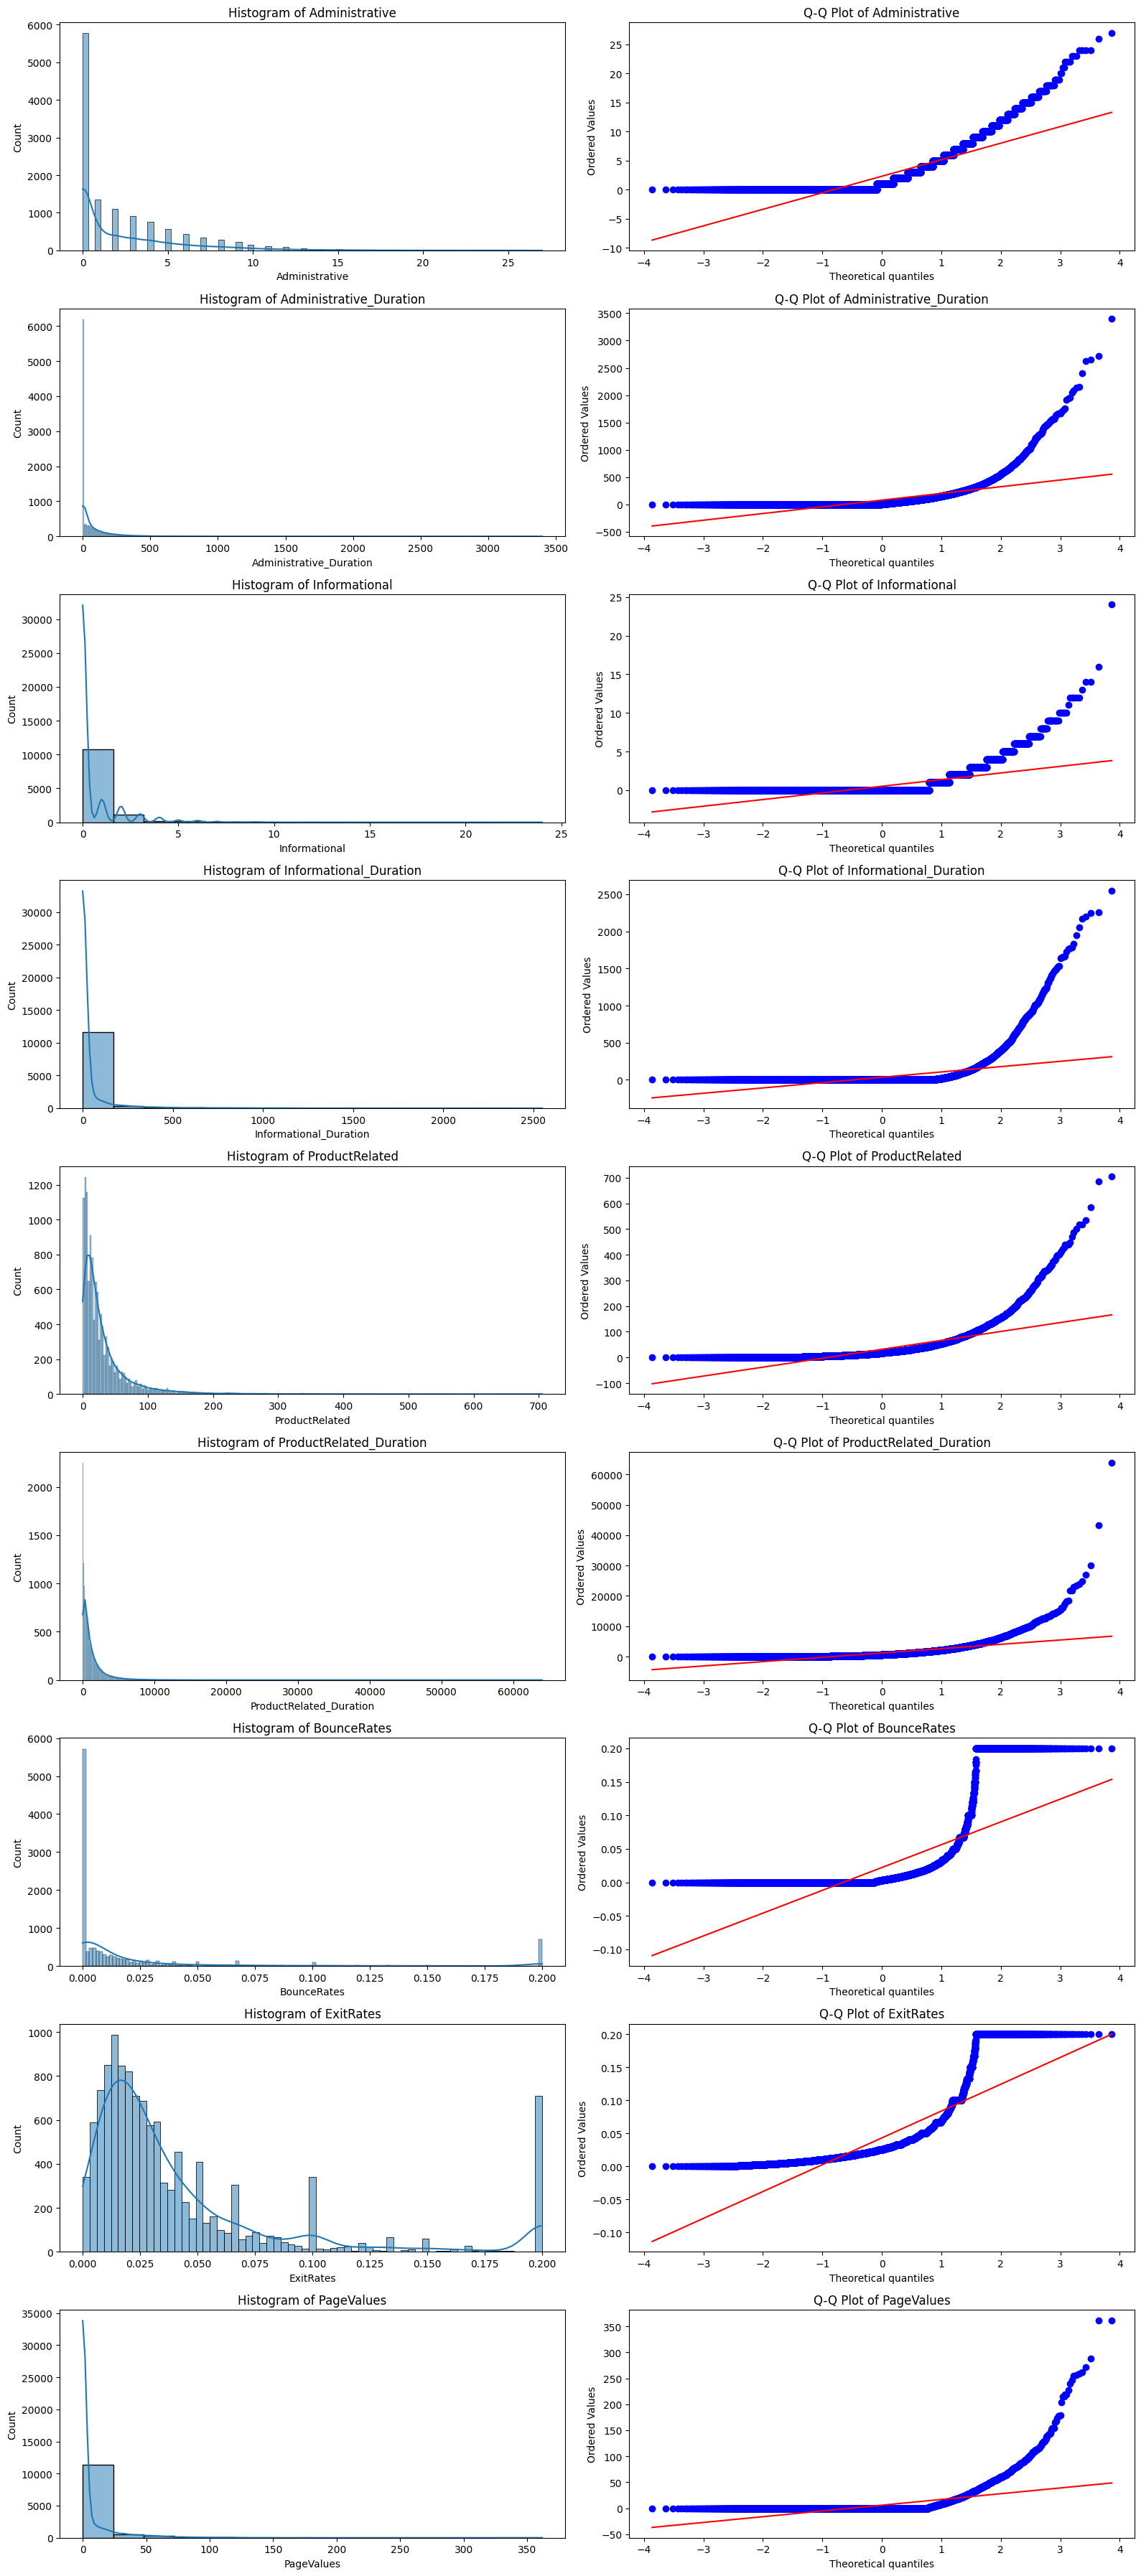

In [6]:
plot_data_distribution(df=df, features_to_plot=numerical_features)

As plotted above, non of the features are following normal distribution. The features are mostly skewed to the right.

This is important insight when normalizing/ standardizing features and when choosing machine learning models.

In [7]:
# observe member of each category
unq_cat = {i: df[i].unique() for i in categorical_features}
unq_cat

{'OperatingSystems': array([1, 2, 4, 3, 7, 6, 8, 5]),
 'Browser': array([ 1,  2,  3,  4,  5,  6,  7, 10,  8,  9, 12, 13, 11]),
 'Region': array([1, 9, 2, 3, 4, 5, 6, 7, 8]),
 'TrafficType': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19,
        16, 17, 20]),
 'SpecialDay': array([0. , 0.4, 0.8, 1. , 0.2, 0.6])}

In [8]:
columns_to_encode = ["VisitorType", "Weekend", "Month"]

##### Check for class imbalance
As the results indicate bellow, there is a big class imbalance in the dataset which should be taken into account moving forward. Specially, when it is time to decide on models performance evaluation methods.

In [9]:
unique_classes = df["Revenue"].unique()
print(f"In the entire dataset there are the following classes {unique_classes}")
count_true = df[df["Revenue"]==True]["Revenue"].count()
count_false = df[df["Revenue"]==False]["Revenue"].count()
# make sure that all the classes counts is considered
assert df.shape[0]-(count_false+count_true) == 0 
# get percentage of each class 
print(f"Percentage of class True: {(count_true/df.shape[0])*100}")
print(f"Percentage of class False: {(count_false/df.shape[0])*100}")


In the entire dataset there are the following classes [False  True]
Percentage of class True: 15.474452554744525
Percentage of class False: 84.52554744525548


##### Best selling month
This analysis is to answer RQ3, Which time of the year is best to increase advertisement on the website?
As shown in the bar graph bellow, there is an overall upward trend in `Revenue` as approaching the end of the year with Nov, Oct and Sep are the best selling months, respectively. Interestingly, there is a revenue decrease in the Dec. It is worth mentioning that there is missing data for the following months: Jan, Apr, Jun

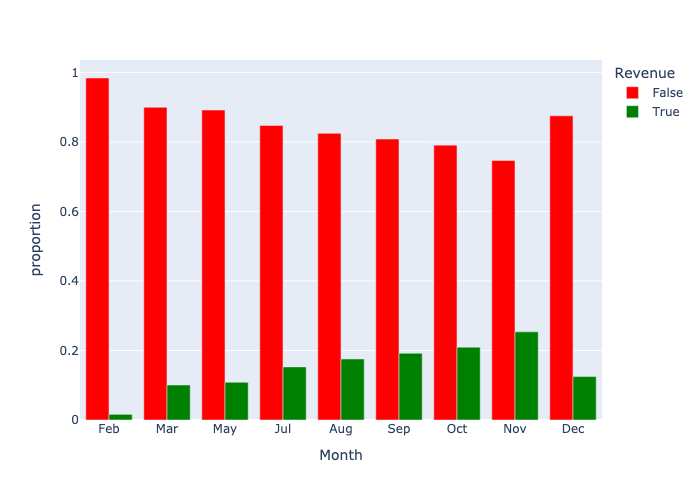

In [10]:
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df["Month"] = pd.Categorical(df["Month"], categories=months_order, ordered=True)

best_selling_month = df.groupby(by=["Month"], observed=True)["Revenue"].value_counts(normalize=True).reset_index(inplace=False).sort_values(by=["Month"])

fig = px.bar(best_selling_month, x="Month", y="proportion", barmode="group", color="Revenue", color_discrete_map={True: "Green", False: "red"})
fig.show(renderer="png")

##### Correlation analysis

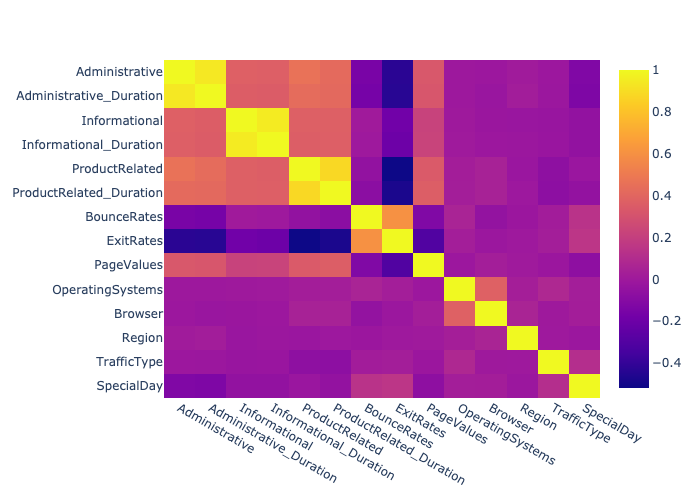

In [11]:
# check the correlation between features, WRT target "Revenue"
corr = df[numerical_features+categorical_features].corr(method="spearman")
corr
fig = px.imshow(corr, text_auto=False, aspect="auto")
fig.show(renderer="png")

Having a closer look at the figure above, it is clear that `Administrative`, `Informational`, and `ProductRelated` are highly correlated with the `Administrative_Duration`, `Informational_Duration`, and `ProductRelated_Duration` respectively.

Interestingly, `Revenue` is highly correlated with `PageValues`, and then `ProductRelated_Duration`, `ProductRelated`. Moreover, `Revenue` is negatively correlated with `BounceRates` and `ExitRates` which makes sense.

Looking at the rest of the dataset, those features seem to not have much correlation with the `Revenue`, however, `SpecialDay` is slightly correlated with `BounceRates` and `ExitRates` which means, close to special days, there are more chances of people open the website for shopping but the search does not lead to actual purchase.

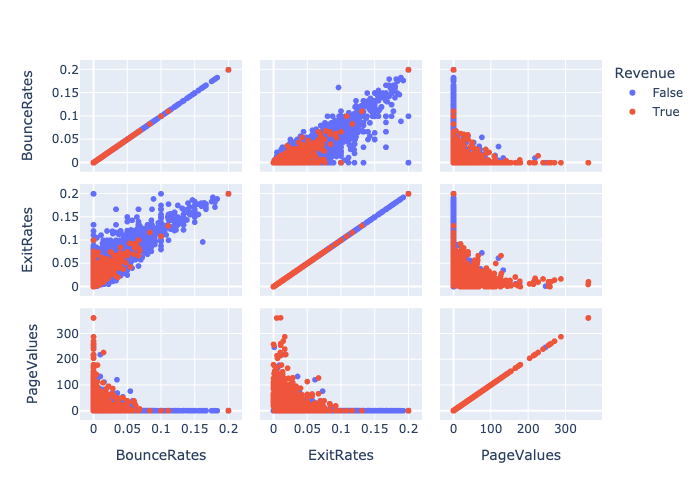

In [12]:
# check the correlation between "BounceRates", "ExitRates", "PageValues" features, WRT target "Revenue"
fig = px.scatter_matrix(df, dimensions=["BounceRates", "ExitRates", "PageValues"], color="Revenue")
fig.show(renderer="png")

As the above figure indicates, there is a linear correlation between BounceRates and ExitRates.
Interesting point to note is that there is some data points where meets the following condition 
`(df["BounceRates"]>=0.2)&(df["PageValues"]==0)&(df["ExitRates"]>=0.2)`
however, the label for them are different.
So, even though these are only 3 features out of the 17 presented features, theses are important features, thus, it worth to make sure that there are NO records in the dataset with exact same features, and different labels, as such records can really confuse the models.  

In [13]:
# find if there are any records with same feature values, but diff labels
# group by all columns except the label
grouped = df.groupby(df.columns.difference(["Revenue"]).tolist())
# filter groups that have more than one unique label
conflicting_groups = grouped.filter(lambda x: x["Revenue"].nunique() > 1)
conflicting_groups

/var/folders/pj/jctcjw1d55n7xkxm3n3w6ynm0000gp/T/ipykernel_84140/3195972393.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


Given that `conflicting_groups` is an empty df, we can be sure that the mentioned problem does not exist in the current dataset.

Concluding the correlation analysis, given that some of the features are correlated to each other, some of the highly correlated features can be removed, if we aim for feature dimensionality reduction. Also, now we know which features are more important than others, those which are highly correlated with the target `Revenue` have the potential to help the ML models learn more effectively.

#### Train-Test data split
Allocate 20% of the data for testing purposes. Also, set the `shuffle=True`, to improve generalization and also to avoid bias to sequential data.

In [14]:
X_trn, X_tst, y_trn, y_tst = train_test_split(df.drop(columns=["Revenue"]), df["Revenue"], test_size=0.2, random_state=72, shuffle=True)
X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape


((9864, 17), (2466, 17), (9864,), (2466,))

#### Data normalization/ standardization
It is a common mistake that normalization happens before data train-test split. Here is the reason why this should not happen:
- Note that the aim of data split is to make sure that there is no leak of information form the test set to the train set.
- Also note that the most of the normalization techniques, such as MinMaxScaler or StandardScaler use some statistic information from the entire dataset that is passed to the formula, e.g. the Max of the entire dataset (for each column obviously!)
- The max of entire dataset is NOT necessarily equal to the max of the train set 
- When normalizing the entire dataset, then split the data, the test set is divided by the max of the entire dataset, meaning some of the test set info had leaked into the train set.

In [15]:

scaler = StandardScaler()
X_trn_nrm, trn_scaler = data_normalizer(df=X_trn, column_name_to_normalize=numerical_features+categorical_features, scaler=scaler)
# Normalize test set using the scaler that fitted to the train set
# In real world scenario, the scaler info should be stored for later use
X_tst_nrm, _ = data_normalizer(df=X_tst, column_name_to_normalize=numerical_features+categorical_features, scaler=trn_scaler)
display(X_trn_nrm.head(3))
display(X_tst_nrm.head(3))


,Month,VisitorType,Weekend,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,OperatingSystems,Browser,Region,TrafficType,SpecialDay
3663,May,Returning_Visitor,False,-0.700167,-0.465415,-0.394498,-0.248286,-0.699490,-0.619228,3.633868,3.205361,-0.314614,-1.233299,-0.794261,-0.897983,-0.264425,-0.309753
4718,May,Returning_Visitor,False,-0.700167,-0.465415,-0.394498,-0.248286,-0.262596,-0.489516,-0.243698,-0.194476,-0.314614,-0.138809,-0.213835,-0.482206,2.210465,3.702592
10667,Dec,Returning_Visitor,False,-0.700167,-0.465415,-0.394498,-0.248286,-0.009658,-0.183104,-0.459119,-0.682477,-0.314614,-0.138809,-0.213835,-0.897983,1.467998,-0.309753


,Month,VisitorType,Weekend,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,OperatingSystems,Browser,Region,TrafficType,SpecialDay
6767,Oct,Returning_Visitor,False,0.217160,-0.201290,-0.404451,-0.234824,-0.310782,-0.266547,-0.239052,-0.477511,-0.331133,0.984080,-0.184129,-0.879103,-0.775908,-0.305078
3068,May,Returning_Visitor,False,-0.083354,-0.250576,-0.404451,-0.234824,-0.227781,-0.403482,-0.452123,-0.371740,-0.331133,0.984080,-0.184129,-0.040956,-0.775908,2.740758
7439,NaN,Returning_Visitor,True,-0.684383,-0.427362,-0.404451,-0.234824,-0.642785,-0.626592,-0.452123,1.214812,-0.331133,-0.125034,-0.184129,-0.460030,-0.271123,-0.305078


#### Encode categorical dataset
Will encode the values of `"VisitorType", "Weekend", "Month"` columns.

In [16]:
encoded_X_trn_nrm = categorical_encoder(df=X_trn_nrm, column_name_to_encode=columns_to_encode)
encoded_X_tst_nrm = categorical_encoder(df=X_tst_nrm, column_name_to_encode=columns_to_encode)
display(encoded_X_trn_nrm.head(3))
display(encoded_X_tst_nrm.head(3))

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,OperatingSystems,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_nan
3663,-0.700167,-0.465415,-0.394498,-0.248286,-0.699490,-0.619228,3.633868,3.205361,-0.314614,-1.233299,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4718,-0.700167,-0.465415,-0.394498,-0.248286,-0.262596,-0.489516,-0.243698,-0.194476,-0.314614,-0.138809,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10667,-0.700167,-0.465415,-0.394498,-0.248286,-0.009658,-0.183104,-0.459119,-0.682477,-0.314614,-0.138809,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,OperatingSystems,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_nan
6767,0.217160,-0.201290,-0.404451,-0.234824,-0.310782,-0.266547,-0.239052,-0.477511,-0.331133,0.984080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3068,-0.083354,-0.250576,-0.404451,-0.234824,-0.227781,-0.403482,-0.452123,-0.371740,-0.331133,0.984080,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7439,-0.684383,-0.427362,-0.404451,-0.234824,-0.642785,-0.626592,-0.452123,1.214812,-0.331133,-0.125034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Model training and grid search
1. Using 4 different machine learning algorithms, namely, support vector classifier (SVC), random forest, XGboost, and K-nearest neighbors.
2. To find the best configuration for each algorithm and to find the best algorithm, I use grid search to systematically find the best model.

#### Model evaluation

As for the model evaluation, given that the dataset is highly imbalanced (i.e. the proportion of website visitors who did NOT purchased a product- the False labels- is much more than those who did buy a product- the True labels), selecting proper evaluation method is important. Accuracy is not practical in this case, as even if all the prediction are `False` i.e. `No Revenue`, the accuracy value will be high because the proportion of class `False` is much more than the class `True`.
Precision, recall, F1 score and area under the ROC curve are more appropriate metric to use, as these metrics are more robust to class imbalance.

Precision is the proportion of the number of `correctly predicted positive` class by total number of `positive predictions`. High precision means minimizing the false positive predictions. However, the false negative predictions are not taken into account. 

In the current project, precision is particularly important if there are <ins>limited financial resources</ins> to ensure that most of the targeted webpage visitors are actually going to buy some product. Also, it this case it does not matter how is the performance for the false negative prediction, as it is OK if some of the visitors who where predicted as a NOT buyer, end up buying some product. 

Recall, on the other hand, focuses on minimizing the number of `false negative` predictions, and does not care about the `false positive` predictions. Which in our case, it means the aim is to reach out to <ins>as many webpage visitors as possible</ins> and resources is not an issue. Thus, it is OK to spend resources to advertise to some visitors who will NOT end up buying any product.

Because this is a demo (there is no set requirements), I will use the `Area under the ROC (roc_auc)` metric to make sure the result is as optimized as possible for both classes.

I also wrote a function which calculates all the above metrics for better insight.


In [17]:
models = {
    "SVC": SVC(probability=True, random_state=72),
    "RandomForest": RandomForestClassifier(random_state=72),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=72),
    "KNN": KNeighborsClassifier(),

}

grid_param = [
    {   "model": [models["SVC"]],
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"],
        "model__gamma": ["scale", "auto"]
    },
    {   "model": [models["RandomForest"]],
        "model__n_estimators": [50, 100, 200, 500],
        "model__max_depth": [None, 5, 10, 20, 25]
    },
    {   "model": [models["XGBoost"]],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__max_depth": [3, 6, 10]
    },
    {
        "model": [models["KNN"]],
        "model__n_neighbors": [3, 5, 7, 10, 15, 23],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"],
    }
]

grid_search = grid_search(
    models=models,
    parameter_grid=grid_param,
    X_train=encoded_X_trn_nrm,
    y_train=y_trn,
    number_cross_val_fold=10,
    scoring_method="roc_auc",
    verbose=0
)

Best parameters: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=72, ...), 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best cross-validation roc_auc score: 0.9328698548591843


#### Evaluating the best model from the grid search result

In [18]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AUC-ROC score:", grid_search.best_score_)

# get the best model
best_model = grid_search.best_estimator_

Best parameters: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=72, ...), 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best cross-validation AUC-ROC score: 0.9328698548591843


As indicated above, the best model is the XGBoost model with the following hyper-parameters `'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100`

Retrain the best model on the entire dataset (instead of number_of_folds - 1 portion of the data)

In [27]:
clf = XGBClassifier(learning_rate=0.1, 
                    max_depth=3,
                    n_estimators=100,
                    eval_metric="logloss", 
                    random_state=72)
clf = clf.fit(encoded_X_trn_nrm, y_trn)


In [28]:
# evaluate on the train set
print("Model evaluation on the train set results: \n")
y_trn_pred = clf.predict(encoded_X_trn_nrm)
y_trn_proba = clf.predict_proba(encoded_X_trn_nrm)[:, 1]
labels = [True, False]
model_evaluation(y_pred=y_trn_pred,
                 y_true=y_trn,
                 y_pred_probability=y_trn_proba,
                 labels=labels,
                 toPrint=True)

# evaluate on the test set
print("Model evaluation on the test set results: \n")
y_tst_pred = clf.predict(encoded_X_tst_nrm)
y_tst_proba = clf.predict_proba(encoded_X_tst_nrm)[:, 1]
model_evaluation(y_pred=y_tst_pred,
                 y_true=y_tst,
                 y_pred_probability=y_tst_proba,
                 labels=labels,
                 toPrint=True)

Model evaluation on the train set results: 

[[ 966  539]
 [ 266 8093]]
              precision    recall  f1-score   support

        True      0.784     0.642     0.706      1505
       False      0.938     0.968     0.953      8359

    accuracy                          0.918      9864
   macro avg      0.861     0.805     0.829      9864
weighted avg      0.914     0.918     0.915      9864

ROC_AUC: 94.78
f1_score_per_class:  [0.70588235 0.95262198]
f1_score_avg:  0.9149756732974458
accuracy:  0.9183901054339011
Model evaluation on the test set results: 

[[ 230  173]
 [  75 1988]]
              precision    recall  f1-score   support

        True      0.754     0.571     0.650       403
       False      0.920     0.964     0.941      2063

    accuracy                          0.899      2466
   macro avg      0.837     0.767     0.796      2466
weighted avg      0.893     0.899     0.894      2466

ROC_AUC: 93.15
f1_score_per_class:  [0.64971751 0.94128788]
f1_score_avg:  0.89

(np.float64(0.9314779242929604),
 array([0.64971751, 0.94128788]),
 np.float64(0.893638707271486),
 0.8994322789943228,
 '              precision    recall  f1-score   support\n\n        True      0.754     0.571     0.650       403\n       False      0.920     0.964     0.941      2063\n\n    accuracy                          0.899      2466\n   macro avg      0.837     0.767     0.796      2466\nweighted avg      0.893     0.899     0.894      2466\n',
 array([[ 230,  173],
        [  75, 1988]]))

The ROC-AUC result when testing the trained model on train set is `94.78` and when testing on unseen test set is `93.15`. Given the almost 1.6% difference in the two results, I can conclude that the model is not really overfitted  nor it is underfitted to the train dataset.

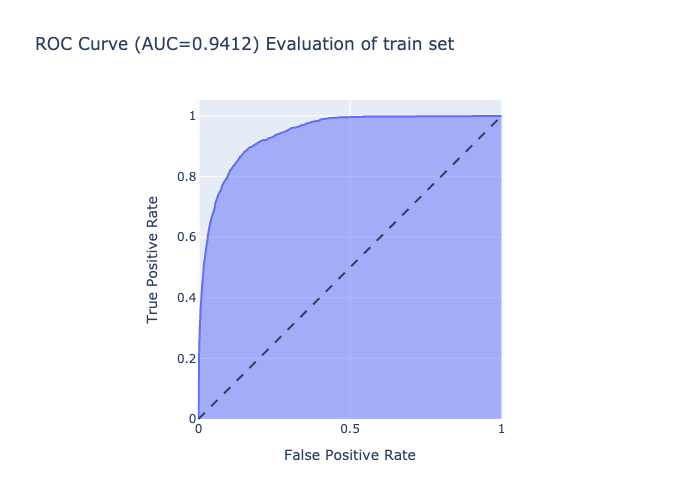

In [21]:
plot_auc_roc_curve(y_true=y_trn, y_probability=y_trn_proba, title="Evaluation of train set")

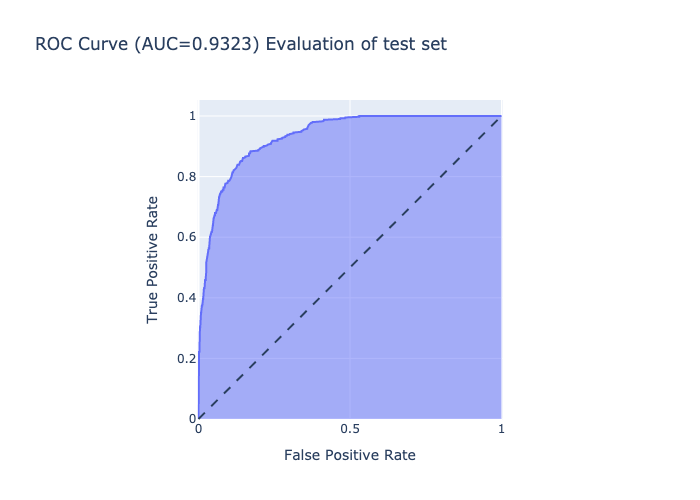

In [22]:
plot_auc_roc_curve(y_true=y_tst, y_probability=y_tst_proba, title="Evaluation of test set")

#### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

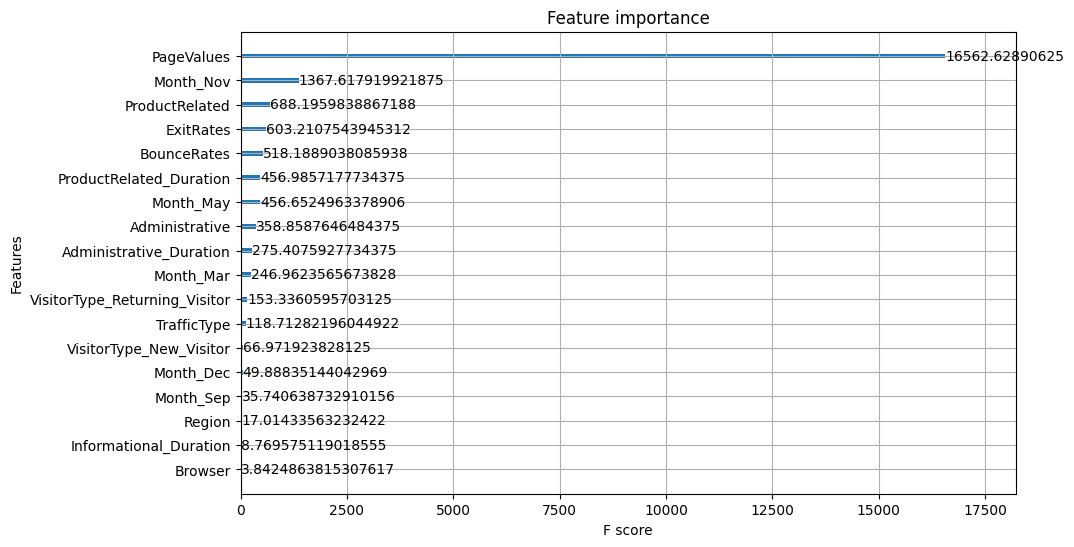

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(clf, ax=ax, importance_type='total_gain',
                    max_num_features=40,
                      show_values=True)


Find the list of important features 

In [25]:
booster = clf.get_booster()
importance_scores = booster.get_score(importance_type='total_gain')
sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
features_by_importance = [feature for feature, score in sorted_features]
features_by_importance

['PageValues',
 'Month_Nov',
 'ProductRelated',
 'ExitRates',
 'BounceRates',
 'ProductRelated_Duration',
 'Month_May',
 'Administrative',
 'Administrative_Duration',
 'Month_Mar',
 'VisitorType_Returning_Visitor',
 'TrafficType',
 'VisitorType_New_Visitor',
 'Month_Dec',
 'Month_Sep',
 'Region',
 'Informational_Duration',
 'Browser']

In [33]:
# using selected features
selected_features = features_by_importance[:20]
# fs stands for feature selection
clf_w_fs = XGBClassifier(learning_rate=0.1, 
                    max_depth=3,
                    n_estimators=100,
                    eval_metric="logloss", 
                    random_state=72)
clf_w_fs = clf_w_fs.fit(encoded_X_trn_nrm[selected_features], y_trn)

# evaluate on the train set
print("Model evaluation on the train set results: \n")
y_trn_pred = clf_w_fs.predict(encoded_X_trn_nrm[selected_features])
y_trn_proba = clf_w_fs.predict_proba(encoded_X_trn_nrm[selected_features])[:, 1]
labels = [True, False]
model_evaluation(y_pred=y_trn_pred,
                 y_true=y_trn,
                 y_pred_probability=y_trn_proba,
                 labels=labels,
                 toPrint=True)

# evaluate on the test set
print("Model evaluation on the test set results: \n")
y_tst_pred = clf_w_fs.predict(encoded_X_tst_nrm[selected_features])
y_tst_proba = clf_w_fs.predict_proba(encoded_X_tst_nrm[selected_features])[:, 1]
model_evaluation(y_pred=y_tst_pred,
                 y_true=y_tst,
                 y_pred_probability=y_tst_proba,
                 labels=labels,
                 toPrint=True)

Model evaluation on the train set results: 

[[ 969  536]
 [ 262 8097]]
              precision    recall  f1-score   support

        True      0.787     0.644     0.708      1505
       False      0.938     0.969     0.953      8359

    accuracy                          0.919      9864
   macro avg      0.863     0.806     0.831      9864
weighted avg      0.915     0.919     0.916      9864

ROC_AUC: 94.76
f1_score_per_class:  [0.70833333 0.95303672]
f1_score_avg:  0.9157010984989071
accuracy:  0.9190997566909975
Model evaluation on the test set results: 

[[ 228  175]
 [  73 1990]]
              precision    recall  f1-score   support

        True      0.757     0.566     0.648       403
       False      0.919     0.965     0.941      2063

    accuracy                          0.899      2466
   macro avg      0.838     0.765     0.795      2466
weighted avg      0.893     0.899     0.893      2466

ROC_AUC: 93.08
f1_score_per_class:  [0.64772727 0.94134342]
f1_score_avg:  0.89

(np.float64(0.9308320172626772),
 array([0.64772727, 0.94134342]),
 np.float64(0.8933599254845689),
 0.8994322789943228,
 '              precision    recall  f1-score   support\n\n        True      0.757     0.566     0.648       403\n       False      0.919     0.965     0.941      2063\n\n    accuracy                          0.899      2466\n   macro avg      0.838     0.765     0.795      2466\nweighted avg      0.893     0.899     0.893      2466\n',
 array([[ 228,  175],
        [  73, 1990]]))

#### Conclusion:

Based on the grid search results XGboost out performed the rest of the models in predicting whether or not a website visitor will actually purchase a product. XGboost classifier is using the ensemble method which in simple words it is using votes from all the estimators to finalize a prediction about an instance.

Based on the evaluation results, the area under the ROC curve and F1 score of 93.15%, 89.36%, respectively, shows the models performance is acceptable. Precision of 75.4% (for the minority class, the class `True`) indicates that the model is specially useful if there are there are limited financial resources to advertise the products and it is important to advertise mainly to those who are most probably actual buyers 

As for feature selection, I used the feature importance method of the XGboost algorithm and selected the top 15 features, however, it was not helpful in the prediction process. It is worth trying other approaches to evaluate the impact of feature set dimensionality reduction.

Thank you for checking my work :) 